In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

#### Import datasets

Marionette strains.

In [2]:
fluos = []
ods = []
for i in range(4):
    fluos.append(pd.read_csv('datasets/bulk_fluo_mario_' + '{:02b}'.format(int(i)) + '.csv', index_col='time').iloc[:,:9]) #removing control data
    ods.append(pd.read_csv('datasets/od_mario_' + '{:02b}'.format(int(i)) + '.csv', index_col='time').iloc[:,:9]) #removing control data

#list of the gate names
gates = fluos[0].columns.tolist()

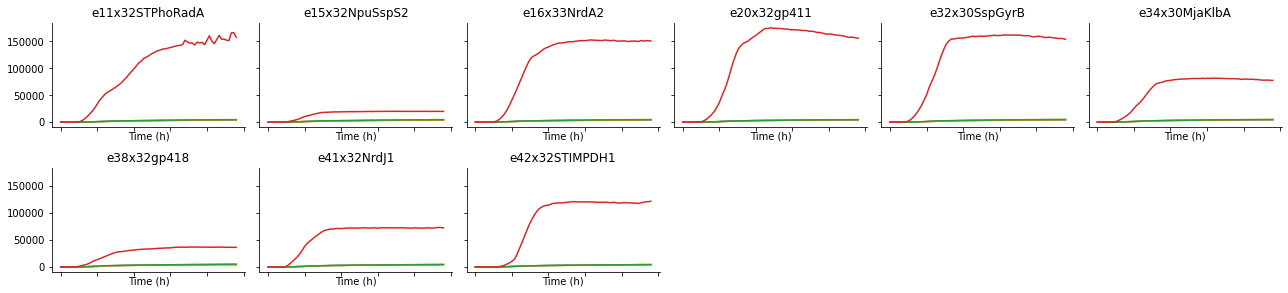

In [3]:
def plot_data(data, cols, num_row, num_col):
    
    f, axs = plt.subplots(num_row, num_col, sharex=True, sharey=True, figsize=(num_col*3, num_row*2))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(cols):
            for j in range(4):
                ax.plot(data[j].index/60, data[j][cols[i]], label=cols[i])
            ax.set_title(cols[i])
            ax.set_xlabel('Time (h)')
        else:
            ax.set_visible(False)
    plt.tight_layout()
    sns.despine()
    
#plot bulk fluorescence data
plot_data(fluos, gates, 4, 6)

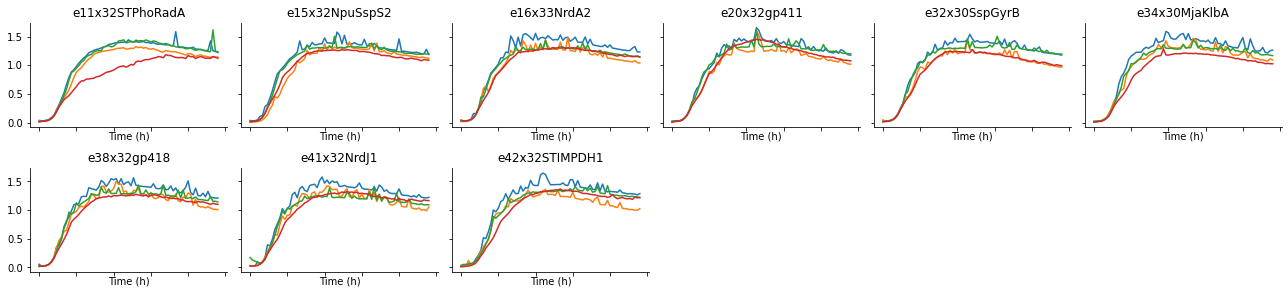

In [4]:
plot_data(ods, gates, 4, 6)

#### ODE Models

In [5]:
def growth_rate(t, OD, alpha, beta):
    return (alpha * (1 - (OD/beta)))

def od_wrapper(t, k1, k2, c0):
    
    def od_model(OD, t, mgr, mcc):
        dOD = growth_rate(t, OD[0], mgr, mcc) * OD[0]
        return dOD
    
    od_rates = (k1, k2)
    od_sol = odeint(od_model, c0, t, od_rates)
    return od_sol[:,0]

def od_inference(od):
    od_bounds = [(0, 0, 0), (1, 2, 0.1)]
    od_params = []
    od_t = od.index
    for idx in range(od.shape[1]):
        od_data = od.iloc[:,idx]
        opt, _ = curve_fit(od_wrapper, od_t, od_data, bounds=od_bounds)
        od_params.append(opt)
    return od_params

In [6]:
#model
def hill_equation(x, K, n):
    return x**n / (K**n + x**n)

#model with auto-fluorescence term
def gate_wrapper_complete(t, bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, a, K, n, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        ECFn, ECFc, ECF, GFP, Auto, OD = y
        
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dECFn = bn + syn_ECFn * ind1 - (deg + gamma) * ECFn
        dECFc = bc + syn_ECFc * ind2 - (deg + gamma) * ECFc
        dECF = syn_ECF * ECFn * ECFc - (deg + gamma) * ECF
        
        dGFP = bg + syn_GFP * hill_equation(ECF, K, n) - (deg_GFP + gamma) * GFP
        dAuto = a - gamma * Auto

        return [dECFn, dECFc, dECF, dGFP, dAuto, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

#model without auto-fluorescence term
def gate_wrapper(t, bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        ECFn, ECFc, ECF, GFP, OD = y
        
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dECFn = bn + syn_ECFn * ind1 - (deg + gamma) * ECFn
        dECFc = bc + syn_ECFc * ind2 - (deg + gamma) * ECFc
        dECF = syn_ECF * ECFn * ECFc - (deg + gamma) * ECF
        
        dGFP = bg + syn_GFP * hill_equation(ECF, K, n) - (deg_GFP + gamma) * GFP

        return [dECFn, dECFc, dECF, dGFP, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

#### Fitting a Single Gate

Select a single gate for the first try.

In [41]:
sel = 1
gate = gates[sel]
print(sel, gate)

#concat all induction states of the corresponding gate
fluo_sel = pd.concat([fluos[i].iloc[:,sel] for i in range(4)], axis=1)
od_sel = pd.concat([ods[i].iloc[:,sel] for i in range(4)], axis=1)

1 e15x32NpuSspS2


In [8]:
#modeling OD
od_params_sel = od_inference(od_sel)

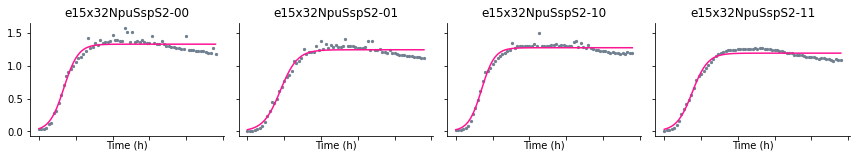

In [9]:
f, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(12, 4))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(od_params_sel):
        r, K, c0 = od_params_sel[i]
        ax.scatter(od_sel.index/60, od_sel.iloc[:, i], c='slategrey', s=5)
        ax.plot(od_sel.index/60, od_wrapper(od_sel.index, r, K, c0), c='deeppink')
        ax.set_title(od_sel.columns[i] + '-' + format(i, '02b'))
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

#### Fitting Only 11 State

In [10]:
#objective function
def computeSSE(init_params, f_t, f_data, bounds, od_params, ind1, ind2):
    
    extra = (od_params[0], od_params[1])
    y0 = pd.Series(np.append(np.zeros(5), od_params[2]))
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k, l):
        fit = gate_wrapper_complete(t, a, b, c, d, e, f, g, h, i, j, k, l, ind1, ind2, extra, y0)
        return pd.Series(fit[3]) + pd.Series(fit[4])
    
    f_params, _ = curve_fit(model_fit, f_t, f_data, p0=init_params, bounds=bounds)
    solution = model_fit(f_t, *f_params)
    error = [(val-sal)**2 for val, sal in zip(solution, f_data)]
    
    return sum(error)

#generate random numbers from a uniform distribution for the initial guesses
def randomSearch(iterations, num_params, f_t, f_data, bounds, od_params, ind1, ind2):
    
    initialGuesses = []
    for k in tqdm(range(iterations)):
        guess = [np.random.uniform(low=low, high=high) for low, high in zip(bounds[0], bounds[1])]
        error = computeSSE(guess, f_t, f_data, bounds, od_params, ind1, ind2)
        initialGuesses.append((error, guess))
    
    sortedGuesses = sorted(initialGuesses)
    bestGuess = sortedGuesses[0][1]
    
    return bestGuess

In [16]:
par = {
    'bn': 1 * 10**-1,
    'bc': 1 * 10**-1,
    'bg': 1 * 10**-2,
    'syn_ECFn': 4 * 10**0,
    'syn_ECFc': 4 * 10**0,
    'syn_ECF': 50 * 10**-10,
    'deg': 7 * 10**-3,
    'syn_GFP': 1 * 10**4,
    'deg_GFP': 1 * 10**-2,
    'a': 1 * 10**-2,
    'K': 1 * 10**-1,
    'n': 2 * 10**0
}

def fit_single_state(fluo, od_params, ind1, ind2):
    
    parameters = list(par.keys())
    f_t = fluo.index
    f_data = fluo.copy()
    extra = (od_params[0], od_params[1])
    y0 = pd.Series(np.append(np.zeros(5), od_params[2]))
    
    #without sampling initial guesses
    init_guesses = [par[i] for i in parameters]
    lower_bounds = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
    upper_bounds = [1e1, 1e1, 1e1, 1e2, 1e2, 1e-4, 1e-1, 1e5, 1e0, 1e1, 1e2, 4]
    gate_bounds = [lower_bounds, upper_bounds]
    
    '''
    #with sampling initial guesses
    lower_bounds = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
    upper_bounds = [1e1, 1e1, 1e1, 1e2, 1e2, 1e-3, 1e-0, 1e5, 1e0, 1e1, 1e2, 5]
    gate_bounds = [lower_bounds, upper_bounds]
    init_guesses = randomSearch(10, len(parameters), f_t, f_data, gate_bounds, od_params, ind1, ind2)
    '''
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k, l):
        fit = gate_wrapper_complete(t, a, b, c, d, e, f, g, h, i, j, k, l, ind1, ind2, extra, y0)
        return pd.Series(fit[3]) + pd.Series(fit[4])
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses, bounds=gate_bounds)
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_t, f_data

In [12]:
n = 3 #induction state in decimal
f_df, f_sim, f_t, f_data = fit_single_state(fluo_sel.iloc[:,n], od_params_sel[n], int(n/2), n%2)

100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


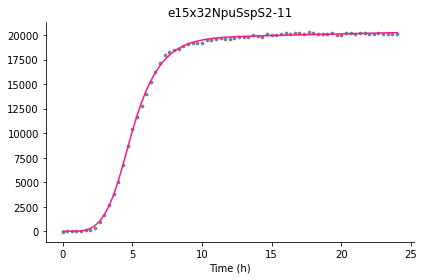

In [13]:
plt.scatter(f_t/60, f_data, c='slategrey', s=7)
plt.plot(f_t/60, f_sim, c='deeppink')
plt.title(gate + '-' + format(3, '02b'))
plt.xlabel('Time (h)')
plt.tight_layout()
sns.despine()

#### Fitting All Gates

In [14]:
f_dfs = []
f_sims = []
f_ts = []
f_datas = []
for sel, gate in tqdm(enumerate(gates)):
    
    gate = gates[sel]
    fluo_sel = pd.concat([fluos[i].iloc[:,sel] for i in range(4)], axis=1)
    od_sel = pd.concat([ods[i].iloc[:,sel] for i in range(4)], axis=1)
    
    od_params_sel = od_inference(od_sel)
    
    f_df, f_sim, f_t, f_data = fit_single_state(fluo_sel.iloc[:,n], od_params_sel[n], int(n/2), n%2)
    f_dfs.append(f_df)
    f_sims.append(f_sim)
    f_ts.append(f_t)
    f_datas.append(f_data)

0it [00:00, ?it/s]
100%|██████████| 10/10 [00:51<00:00,  5.16s/it]
1it [00:57, 57.62s/it]
100%|██████████| 10/10 [00:28<00:00,  2.81s/it]
2it [01:33, 44.66s/it]
100%|██████████| 10/10 [00:49<00:00,  4.92s/it]
3it [02:27, 49.05s/it]
100%|██████████| 10/10 [00:52<00:00,  5.24s/it]
4it [03:23, 51.96s/it]
100%|██████████| 10/10 [00:55<00:00,  5.57s/it]
5it [04:24, 55.13s/it]
100%|██████████| 10/10 [00:38<00:00,  3.82s/it]
6it [05:11, 52.28s/it]
100%|██████████| 10/10 [00:34<00:00,  3.47s/it]
7it [05:52, 48.52s/it]
100%|██████████| 10/10 [00:47<00:00,  4.79s/it]
8it [06:54, 52.99s/it]
100%|██████████| 10/10 [01:05<00:00,  6.54s/it]
9it [08:12, 54.78s/it]


Fitting with sampling initial guesses.

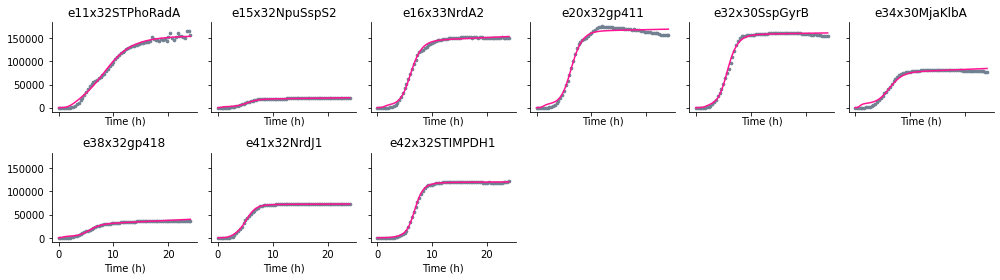

In [15]:
f, axs = plt.subplots(2, 6, sharex=True, sharey=True, figsize=(14, 4))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.scatter(f_ts[i]/60, f_datas[i], c='slategrey', s=7)
        ax.plot(f_ts[i]/60, f_sims[i], c='deeppink')
        ax.set_title(gates[i])
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

Fitting without sampling initial guesses.

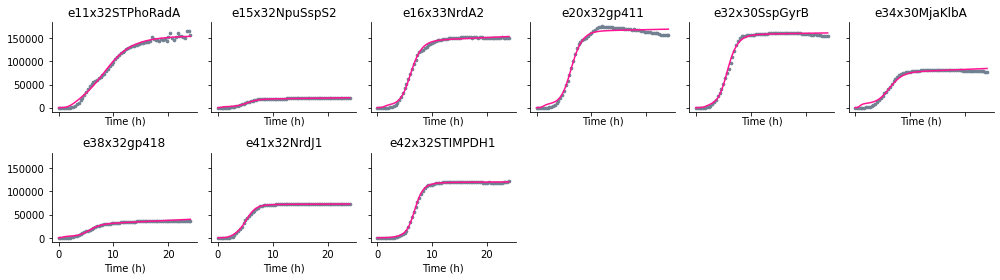

In [18]:
f, axs = plt.subplots(2, 6, sharex=True, sharey=True, figsize=(14, 4))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.scatter(f_ts[i]/60, f_datas[i], c='slategrey', s=7)
        ax.plot(f_ts[i]/60, f_sims[i], c='deeppink')
        ax.set_title(gates[i])
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

#### Parameters Analysis

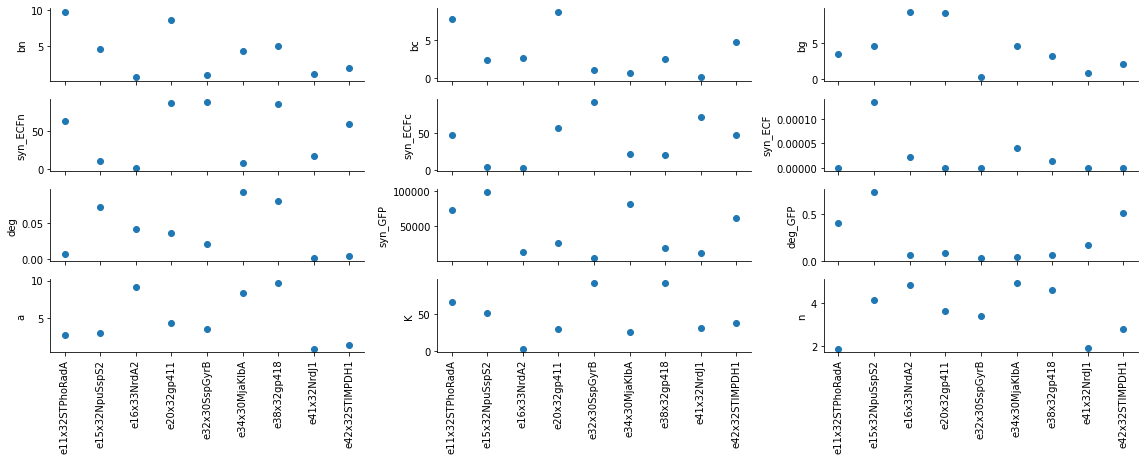

In [20]:
def plot_parameters(f_df, show_err=False):
    
    parameters = f_df[0]['Parameters'].values
    n_paras = len(parameters)
    values = np.stack([df['Value'].values for df in f_df])
    errors = np.stack([df['Err'].values for df in f_df])
    
    f, axs = plt.subplots(int(n_paras/3), 3, sharex=True, figsize=(16, (n_paras+1)/2))
    for i, ax in enumerate(axs.ravel()):
        if i < n_paras:
            if show_err:
                ax.errorbar(gates, values[:,i], errors[:,i], fmt='o', label='experiment')
            else:
                ax.scatter(gates, values[:,i], label='experiment')
            ax.set_ylabel(parameters[i])
        else:
            ax.set_visible(False)
        #ax.set_xticks(rotation=90) 
        ax.set_xticklabels(gates, rotation=90)
    sns.despine()
    plt.tight_layout()
    
plot_parameters(f_dfs)

#### Simulating Fixed Parameters

In [34]:
#just to simulate parameters without fitting
def simulate_single_state(fluo, od_params, par, ind1, ind2):
    
    parameters = list(par.keys())
    f_t = fluo.index
    f_data = fluo.copy()
    extra = (od_params[0], od_params[1])
    y0 = pd.Series(np.append(np.zeros(5), od_params[2]))
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k, l):
        fit = gate_wrapper_complete(t, a, b, c, d, e, f, g, h, i, j, k, l, ind1, ind2, extra, y0)
        return pd.Series(fit[3]) + pd.Series(fit[4])
    
    f_params = list(par.values())
    f_sim = model_fit(f_t, *f_params)
    return f_sim, f_t, f_data

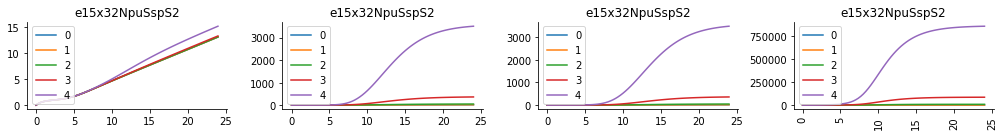

In [43]:
f, axs = plt.subplots(1, 4, figsize=(14, 2), sharey=False)
for i in range(0, 5):
    par = {
        'bn': 1 * 10**-1,
        'bc': 1 * 10**-1,
        'bg': 1 * 10**-2,
        'syn_ECFn': 4 * 10**0,
        'syn_ECFc': 4 * 10**0,
        'syn_ECF': 50 * 10**-10,
        'deg': 7 * 10**-3,
        'syn_GFP': 1 * 10**i,
        'deg_GFP': 1 * 10**-2,
        'a': 1 * 10**-2,
        'K': 1 * 10**-1,
        'n': 2 * 10**0
    }
    for n in range(4):
        f_sim_sin, f_t_sin, f_data_sin = simulate_single_state(fluo_sel.iloc[:,n], od_params_sel[n], par, int(n/2), n%2)
        axs[n].plot(f_t_sin/60, f_sim_sin, label=i)
        axs[n].legend()
        axs[n].set_title(gate)
plt.xticks(rotation=90)
sns.despine()
plt.tight_layout()

In [59]:
par = {
    'bn': 1 * 10**-1,
    'bc': 1 * 10**-1,
    'bg': 1 * 10**-2,
    'syn_ECFn': 4 * 10**0,
    'syn_ECFc': 4 * 10**0,
    'syn_ECF': 50 * 10**-10,
    'deg': 7 * 10**-3,
    'syn_GFP': 1 * 10**4,
    'deg_GFP': 1 * 10**-2,
    'a': 1 * 10**-2,
    'K': 1 * 10**-1,
    'n': 2 * 10**0
}

def fit_all_states(fluo, od_params):
    
    num_states = 4
    num_vars = 5
    
    title = fluo.columns.tolist()[0] #take the first entry only because they are all the same
    f_t = np.concatenate([fluo.index] * num_states)
    f_data = pd.concat([fluo.iloc[:,i] for i in range(num_states)]) 
    y0 = pd.concat([pd.Series(np.append(np.zeros(num_vars), od_params[i][2])) for i in range(num_states)])
    
    #gate_bounds = [lower_bounds, upper_bounds]
    #init_guesses = randomSearch_global(10, len(parameters), f_t, f_data, gate_bounds, od_params)
    
    parameters = list(par.keys())
    init_guesses = list(par.values())
    lower_bounds = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
    upper_bounds = [1e1, 1e1, 1e1, 1e2, 1e2, 1e-4, 1e-1, 1e5, 1e0, 1e1, 1e2, 4]
    gate_bounds = [lower_bounds, upper_bounds]
    
    def model_fit_inner(t, a, b, c, d, e, f, g, h, i, j, k, l, ind1, ind2, extra, y0):
        fit = gate_wrapper_complete(t, a, b, c, d, e, f, g, h, i, j, k, l, ind1, ind2, extra, y0)
        return pd.Series(fit[3]) + pd.Series(fit[4])
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k, l):
        result = [model_fit_inner(fluo.index, a, b, c, d, e, f, g, h, i, j, k, l, int(n/2), n%2, \
                                   (od_params[n][0], od_params[n][1]), np.append(np.zeros(num_vars), od_params[n][2])) \
                                   for n in range(num_states)]
        return pd.concat(result)
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses, bounds=gate_bounds)#, method='dogbox')
    #f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses)
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_t, f_data

In [60]:
f_df_res, f_sim_res, f_t_res, f_data_res = fit_all_states(fluo_sel, od_params_sel)

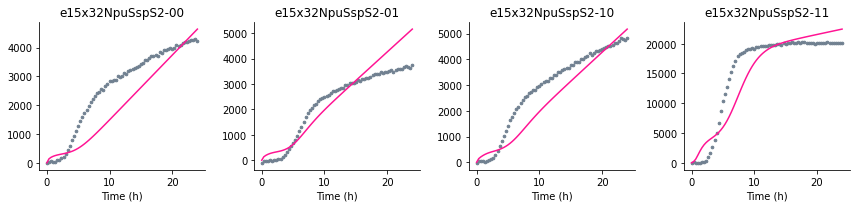

In [61]:
f, axs = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(12, 3))
axr = axs.ravel()
idx = len(fluo_sel.iloc[:,0])
for i, ax in enumerate(axr):
    ax.scatter(f_t_res[idx*i:idx*(i+1)]/60, f_data_res[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.plot(f_t_res[idx*i:idx*(i+1)]/60, f_sim_res[idx*i:idx*(i+1)], c='deeppink')
    ax.set_title(gate + '-' + format(i, '02b'))
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

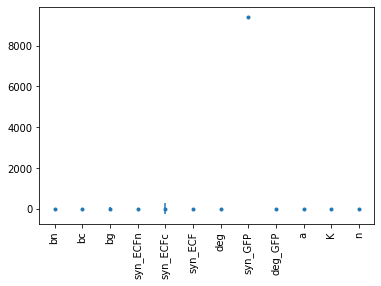

In [62]:
plt.errorbar(f_df_res['Parameters'], f_df_res['Value'], f_df_res['Err'], fmt='.')
plt.xticks(rotation=90)
plt.show()